In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")

print("Path to dataset files:", path)

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d kaustubhdikshit/neu-surface-defect-database

Dataset URL: https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database
License(s): unknown


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/neu-surface-defect-database.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
data = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile


# Data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation
    width_shift_range=0.5,  # Increased width shift
    height_shift_range=0.3,  # Increased height shift
    shear_range=0.6,  # Increased shear
    zoom_range=0.4,  # Increased zoom
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5], #Added brightness augmentation
    channel_shift_range=20, # Added channel shift
    vertical_flip = True, #Added vertical flip

)

val_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(
    directory='/content/NEU-DET/train/images',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    directory='/content/NEU-DET/validation/images',
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical'
)

Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


In [10]:
num_classes = 6

# Resnet50 base
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
)

# Freeze the convolutional base
base_model.trainable = False

# Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Use 'sigmoid' for multi-label classification

])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch, lr: lr * tf.math.exp(-0.1))
opt = optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',  # 'binary_crossentropy' for multi-label classification
    metrics=['accuracy']
)

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,886 (91.90 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

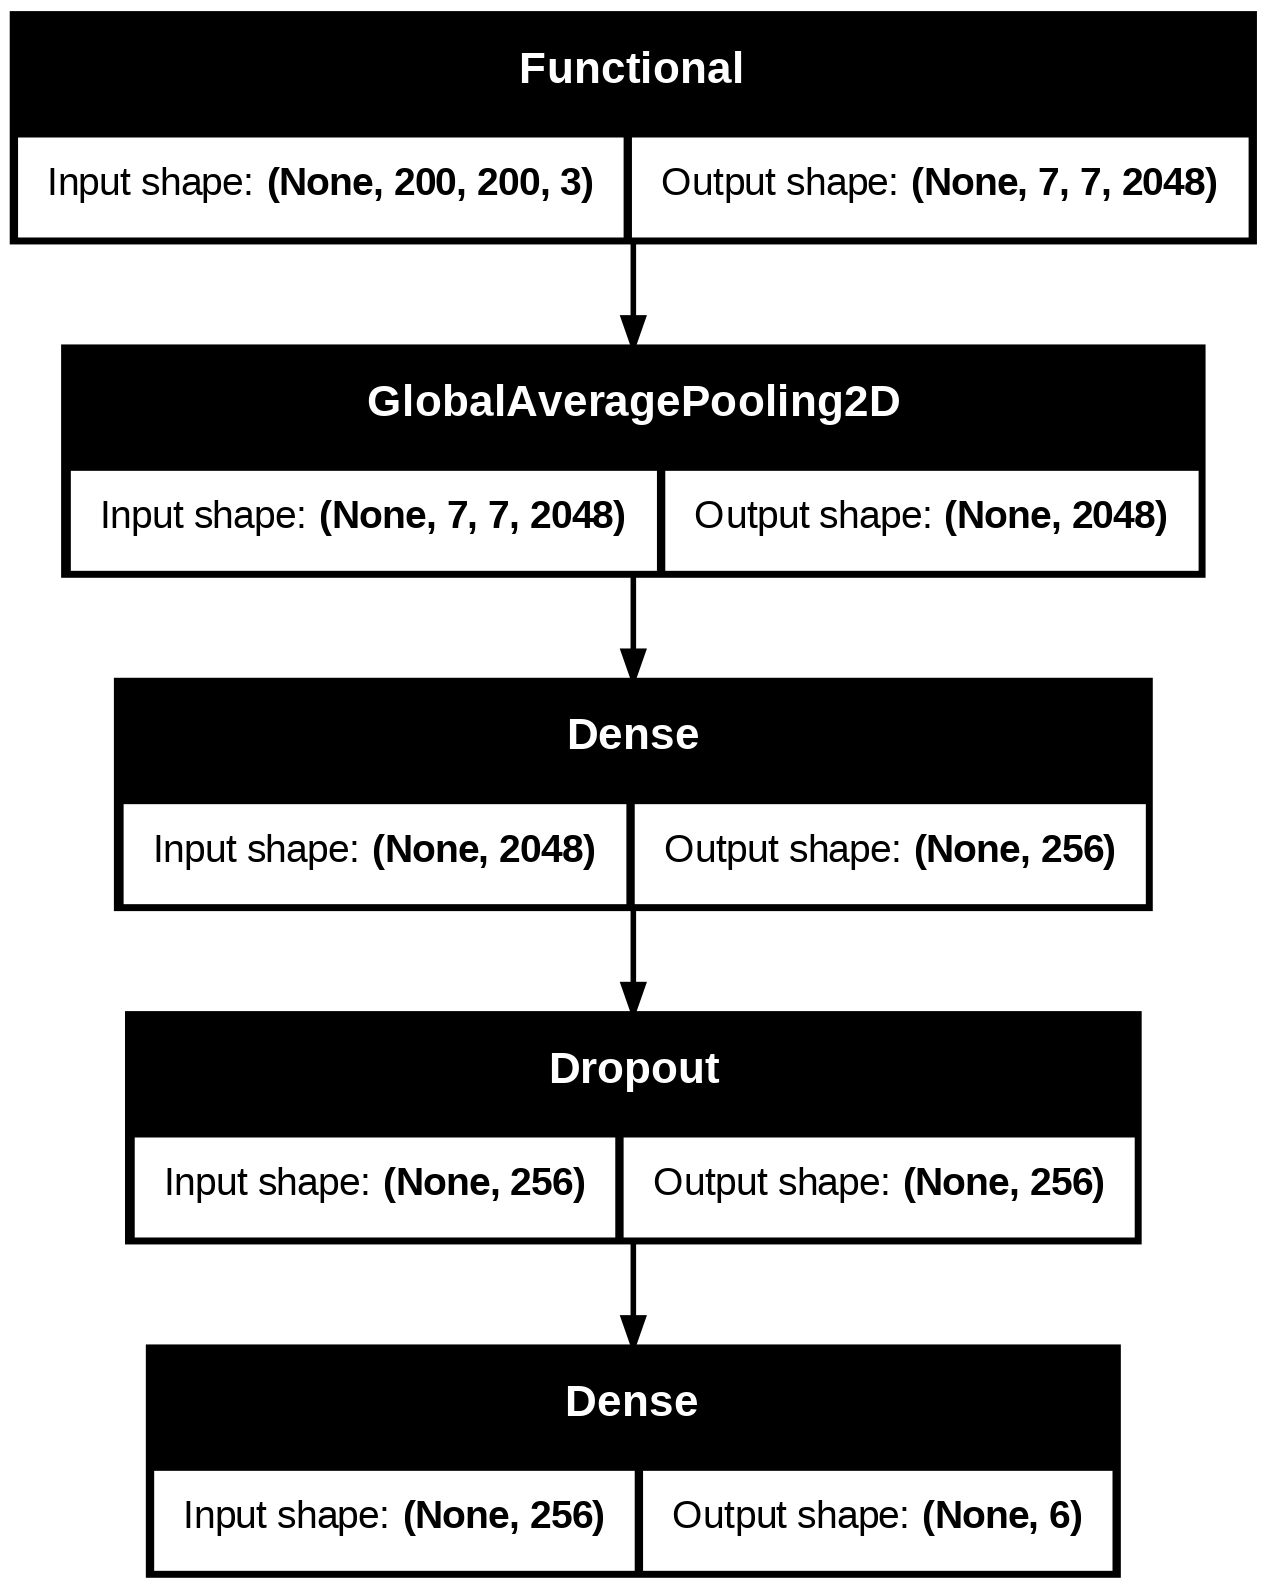

In [13]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)

In [14]:
# Unfreeze more layers for fine-tuning
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [15]:
# Adjust the learning rate for fine-tuning
opt_fine_tune = optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt_fine_tune,
    loss='categorical_crossentropy',  # 'binary_crossentropy' for multi-label classification
    metrics=['accuracy']
)

In [16]:
lr_schedule = LearningRateScheduler(lambda epoch, lr: lr * np.exp(-0.1))

In [17]:
history = model.fit(train_data, steps_per_epoch= len(train_data),
                    epochs = 20, verbose= 1,
                    validation_data = val_data,
                    validation_steps = len(val_data),
                    callbacks=[lr_schedule])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 76s 700ms/step - accuracy: 0.5486 - loss: 1.1615 - val_accuracy: 0.9111 - val_loss: 0.3309 - learning_rate: 9.0484e-05
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 463ms/step - accuracy: 0.9518 - loss: 0.1698 - val_accuracy: 0.9417 - val_loss: 0.1490 - learning_rate: 8.1873e-05
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 459ms/step - accuracy: 0.9493 - loss: 0.1735 - val_accuracy: 1.0000 - val_loss: 0.0047 - learning_rate: 7.4082e-05
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 448ms/step - accuracy: 0.9797 - loss: 0.0745 - val_accuracy: 0.9972 - val_loss: 0.0089 - learning_rate: 6.7032e-05
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 468ms/step - accuracy: 0.9708 - loss: 0.0894 - val_accuracy: 0.9972 - val_loss: 0.0082 - learning_rate: 6.0653e-05
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - accuracy: 0.9691 - loss: 0.0894 - val_accuracy: 1.0000 - val_loss: 0.0064 - learning_rate: 5.4881e-05
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step - acc

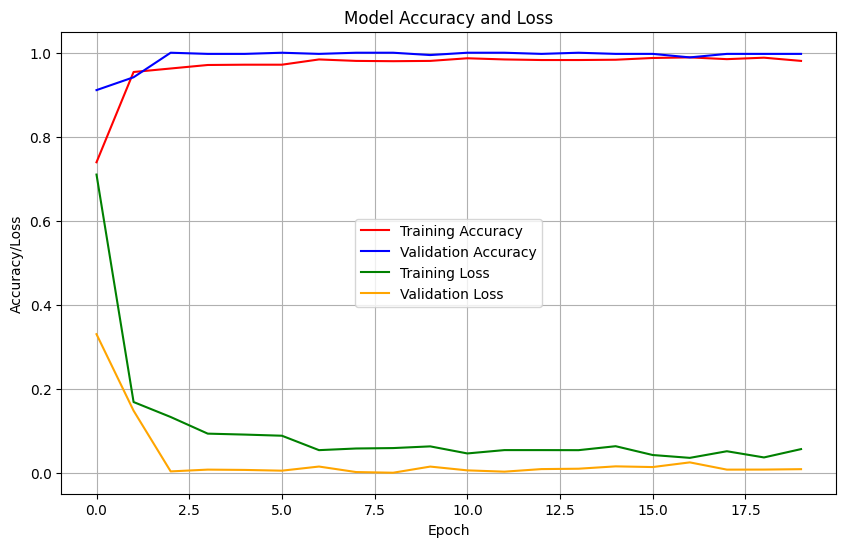

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  # Adjust figure size for better visibility
plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.plot(history.history['loss'], color='green', label='Training Loss') #Plot training loss
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss') #Plot validation loss
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(loc='center') #Specify legend location
plt.grid(True) #Add grid for better readability
plt.show()

In [19]:
# Get a single batch from the generator
images, labels = next(train_data)

# Import required libraries for visualization
import matplotlib.pyplot as plt

# Get the first image from the batch (index 0)
image = images[10]

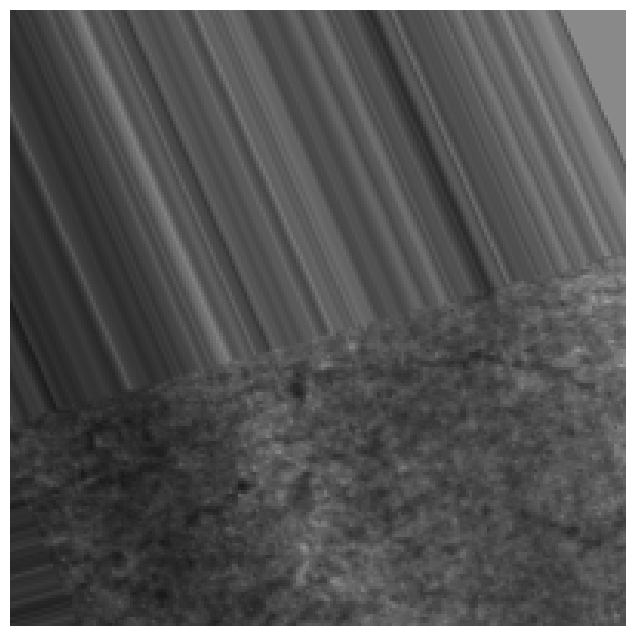

In [20]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [21]:
# If you want to see the corresponding label
print("Label:", labels[0])

Label: [0. 1. 0. 0. 0. 0.]


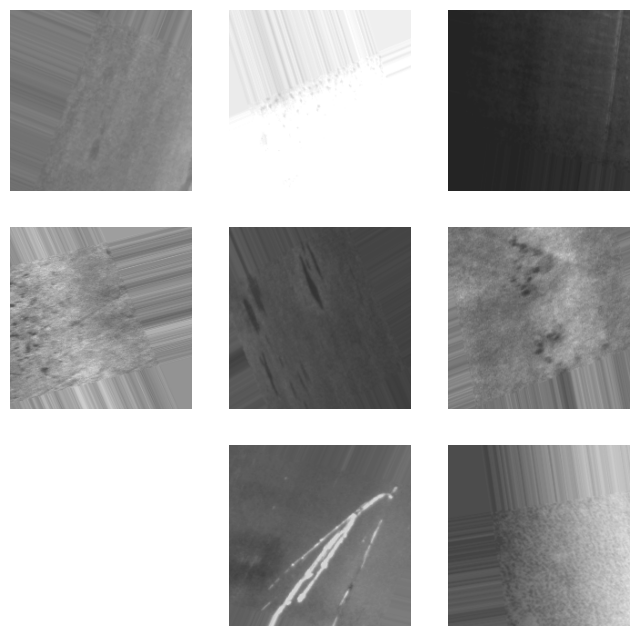

Class names: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [22]:
# To view multiple images from the batch
plt.figure(figsize=(8, 8))
for i in range(9):  # Display first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# You can also get class names from the generator
class_names = list(train_data.class_indices.keys())
print("Class names:", class_names)

In [23]:
import numpy as np
# First, let's see what we have
images, labels = next(val_data)
single_image = images[2]
input_image = np.expand_dims(single_image, axis=0)

# Make prediction
predictions = model.predict(input_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [24]:
# Make prediction
predictions = model.predict(input_image)

# Let's print some debug information
print("Shape of predictions:", predictions.shape)
print("Predicted class index:", np.argmax(predictions[0]))

# Print the actual class_names
print("\nAvailable class names:")
print(train_data.class_indices)

# Now let's fix the visualization
predicted_class = np.argmax(predictions[0])
class_names = list(val_data.class_indices.keys())  # Get class names from data generator

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Shape of predictions: (1, 6)
Predicted class index: 4

Available class names:
{'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}


In [25]:
# Double check if the index is valid
print("\nNumber of classes:", len(class_names))
print("Predicted class index:", predicted_class)


Number of classes: 6
Predicted class index: 4


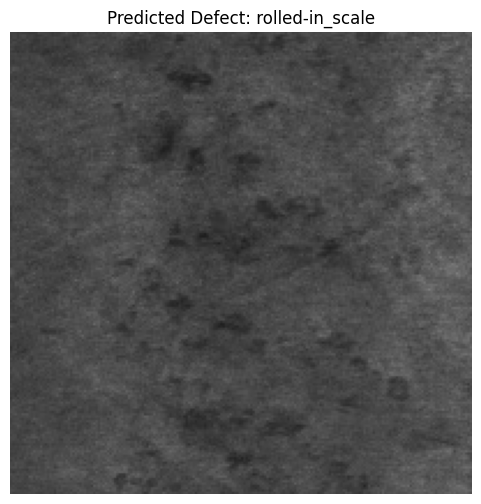

In [26]:
# Now display with verification
plt.figure(figsize=(6, 6))
plt.imshow(single_image)
if predicted_class < len(class_names):
    plt.title(f'Predicted Defect: {class_names[predicted_class]}')
else:
    plt.title(f'Predicted Class Index: {predicted_class} (Warning: Index out of range)')
plt.axis('off')
plt.show()

In [27]:
# Print all probabilities
for i, prob in enumerate(predictions[0]):
    if i < len(class_names):
        print(f'{class_names[i]}: {prob:.2%}')
    else:
        print(f'Class {i}: {prob:.2%}')

crazing: 0.00%
inclusion: 0.00%
patches: 0.00%
pitted_surface: 0.00%
rolled-in_scale: 100.00%
scratches: 0.00%


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 392ms/step
                 precision    recall  f1-score   support

        crazing       0.22      0.22      0.22        60
      inclusion       0.15      0.15      0.15        60
        patches       0.15      0.15      0.15        60
 pitted_surface       0.10      0.10      0.10        60
rolled-in_scale       0.15      0.15      0.15        60
      scratches       0.08      0.08      0.08        60

       accuracy                           0.14       360
      macro avg       0.14      0.14      0.14       360
   weighted avg       0.14      0.14      0.14       360



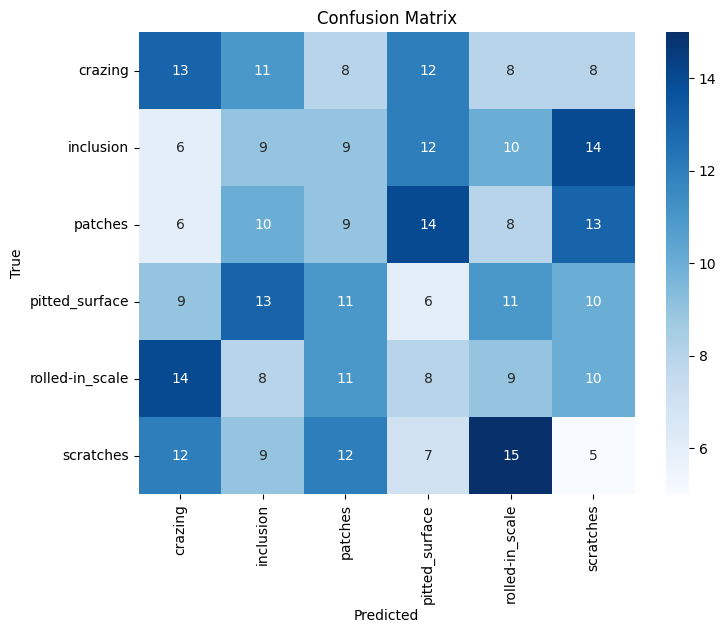

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions for the validation data
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = val_data.classes

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(val_data.class_indices.keys())))

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(val_data.class_indices.keys()),
            yticklabels=list(val_data.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 343ms/step


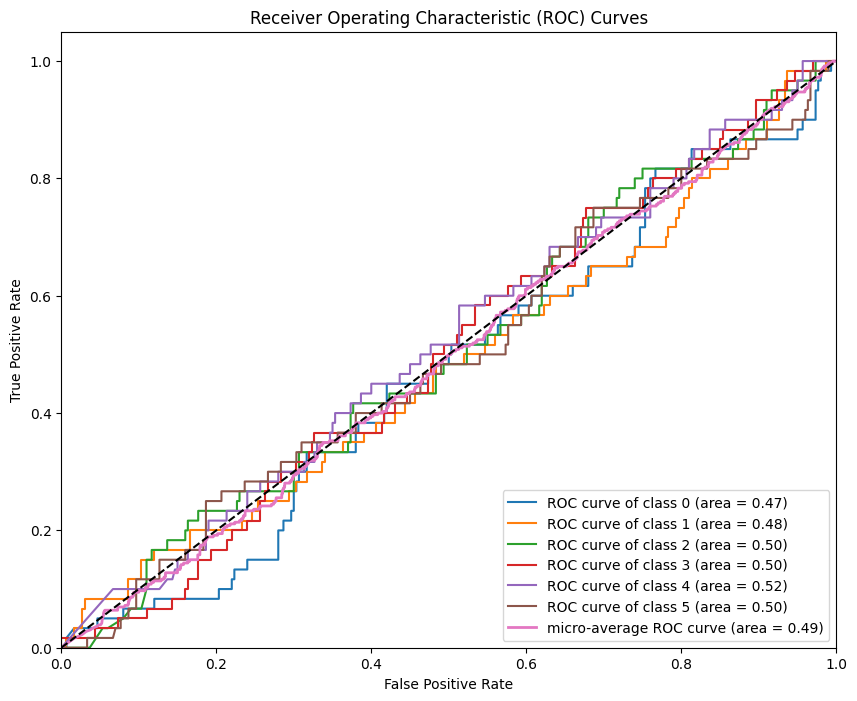

In [33]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ... (Your existing code) ...

# Get predictions for the validation data
y_pred = model.predict(val_data)

# Binarize the output labels
y_true_binarized = label_binarize(val_data.classes, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves for each class and micro-average
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [29]:
model.save('neu_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


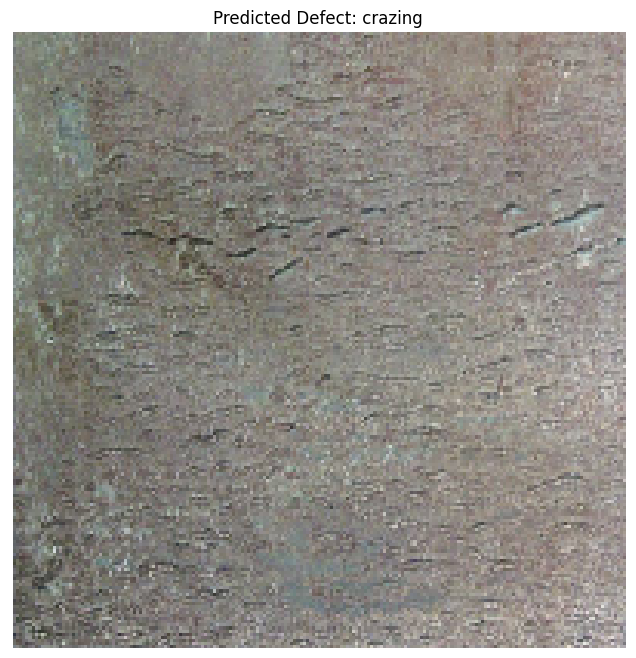


Prediction Probabilities:
crazing: 99.91%
inclusion: 0.02%
patches: 0.01%
pitted: 0.02%
rolled: 0.03%
scratches: 0.01%


In [31]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the saved model
model = load_model('/content/neu_model.keras')

# 2. Function to predict on a single image
def predict_defect(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))  # Use same size as training
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Same normalization as training
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])

    # Define class names - replace with your actual class names
    class_names = ['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']

    # Display image and prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Predicted Defect: {class_names[predicted_class]}')
    plt.axis('off')
    plt.show()

    # Print probabilities for all classes
    print("\nPrediction Probabilities:")
    for i, probability in enumerate(predictions[0]):
        print(f'{class_names[i]}: {probability:.2%}')

# 3. Use the function
predict_defect('/content/Surface-defects-in-a-strip-after-hot-rolling.png')